# 📱Adversarial Attacks on SMS Spam Detectors

Exploring how adversarial learning can be used to target SMS spam detectors using Jacobian based Saliency Map attacks.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
import string

from gensim.models import Word2Vec
import time
import seaborn as sns

import  numpy  as np
import  pandas  as pd
import functools
from  sklearn.preprocessing import  LabelEncoder , MinMaxScaler

import tensorflow as tf
from  tensorflow.python.platform  import  flags
from tensorflow.keras.models import Model
import keras
from  keras.optimizers  import  RMSprop , Adam
from  cleverhans.attacks  import FastGradientMethod, SaliencyMapMethod
from  cleverhans.utils_tf  import  model_train , model_eval , batch_eval, model_argmax
from  cleverhans.attacks_tf  import  jacobian_graph
from  cleverhans.utils  import  other_classes
from cleverhans.model import Model
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans import initializers
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport

import pickle

from keras.layers import Input
from  sklearn.multiclass import  OneVsRestClassifier
from  sklearn.tree import  DecisionTreeClassifier
from  sklearn.ensemble import  RandomForestClassifier , VotingClassifier
from  sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from  sklearn.metrics import  accuracy_score , roc_curve , auc , f1_score, confusion_matrix, classification_report
from  sklearn.preprocessing import  LabelEncoder , MinMaxScaler
from  sklearn.svm  import SVC , LinearSVC
import  matplotlib.pyplot  as plt

stop_words = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packag

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')

display(df)

,label,sms_text
0,not_spam,"Go until jurong point, crazy.. Available only ..."
1,not_spam,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,not_spam,U dun say so early hor... U c already then say...
4,not_spam,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,not_spam,Will Ì_ b going to esplanade fr home?
5569,not_spam,"Pity, * was in mood for that. So...any other s..."
5570,not_spam,The guy did some bitching but I acted like i'd...


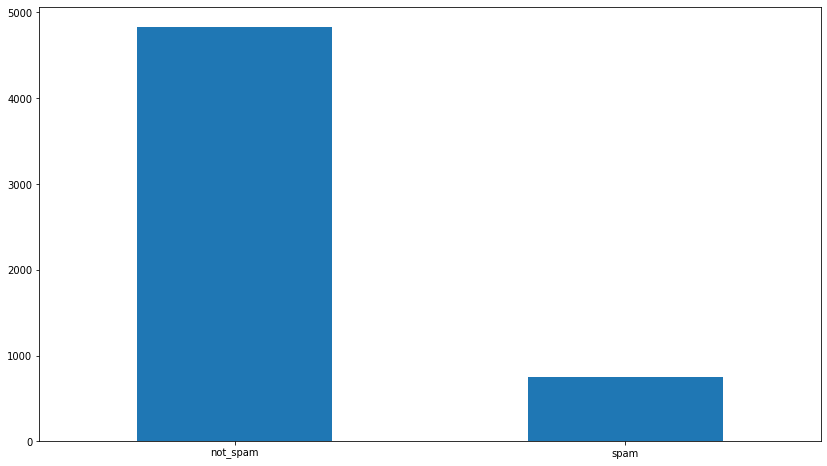

In [3]:
ax = df['label'].value_counts().plot(kind='bar', figsize=(14,8), rot=0)

plt.show()

In [4]:
df['patterns'] = df['sms_text'].apply(lambda x:' '.join(x.lower() for x in x.split()))
df['patterns']= df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if x not in string.punctuation))
df['patterns']= df['patterns'].str.replace('[^\w\s]','')
df['patterns']= df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
df['patterns'] = df['patterns'].apply(lambda x:' '.join(x for x in x.split() if not x in stop_words))
df['patterns'] = df['patterns'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))
df['patterns'] = df.apply(lambda row: nltk.word_tokenize(row['patterns']), axis=1)

display(df)

,label,sms_text,patterns
0,not_spam,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,not_spam,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,not_spam,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,not_spam,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, contact, u, u, å750, pound,..."
5568,not_spam,Will Ì_ b going to esplanade fr home?,"[ì_, b, going, esplanade, fr, home]"
5569,not_spam,"Pity, * was in mood for that. So...any other s...","[pity, mood, soany, suggestion]"
5570,not_spam,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, id, interested, b..."


In [5]:
# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

start_time = time.time()
tokens = pd.Series(df['patterns']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))

word2vec_model_file = 'word2vec_' + str(size) + '.model'
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 2.8230369091033936


In [6]:
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

# Total number of the words 
print("Total number of words")
print(len(sg_w2v_model.wv.vocab))

Total number of words
8355


In [7]:
# Store the vectors for train data in following file
word2vec_filename = 'all_review_word2vec.csv'

with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in df.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['patterns']], axis=0)).tolist()
        
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(size)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
word2vec_df = pd.read_csv(word2vec_filename)
word2vec_df['label'] = df['label']

# Encode labels
word2vec_df = pd.get_dummies(word2vec_df, columns=['label'])

display(word2vec_df.head(10))

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,label_not_spam,label_spam
0,-0.002518,0.005691,0.028719,0.112553,0.004954,-0.000118,-0.047354,0.063511,0.015165,0.065314,...,0.022455,0.023590,0.049012,0.042182,0.067843,0.012421,-0.026096,0.048588,1,0
1,-0.003335,0.006316,0.030497,0.118717,0.004992,0.000358,-0.049837,0.067021,0.016288,0.069339,...,0.024083,0.024686,0.051802,0.044244,0.071909,0.013398,-0.027529,0.051413,1,0
2,-0.001751,0.004171,0.024952,0.101387,0.005779,-0.000073,-0.042342,0.057126,0.014099,0.059079,...,0.020235,0.020780,0.044079,0.038243,0.060210,0.011311,-0.023804,0.043236,0,1
3,-0.004231,0.008591,0.040617,0.158573,0.006669,0.000397,-0.066657,0.089698,0.021396,0.092416,...,0.032019,0.033373,0.069072,0.059283,0.096124,0.017709,-0.036909,0.068895,1,0
4,-0.003645,0.007694,0.037233,0.145041,0.005848,0.000056,-0.060643,0.081297,0.019609,0.084285,...,0.028998,0.030250,0.062514,0.054107,0.087722,0.015767,-0.033356,0.062634,1,0
5,-0.002665,0.006103,0.031361,0.123847,0.005783,-0.000024,-0.051800,0.069786,0.016936,0.072035,...,0.024850,0.025738,0.053763,0.046302,0.074421,0.013556,-0.028769,0.053455,0,1
6,-0.002668,0.005939,0.029417,0.115549,0.005098,-0.000145,-0.048460,0.064702,0.015695,0.067226,...,0.023183,0.024084,0.050333,0.043130,0.069733,0.012727,-0.026763,0.049763,1,0
7,-0.001704,0.003695,0.020013,0.079906,0.003758,-0.000446,-0.033470,0.044813,0.010834,0.046494,...,0.016119,0.016377,0.034478,0.029979,0.047723,0.008557,-0.018586,0.034297,1,0
8,-0.002183,0.004303,0.029799,0.123783,0.007773,-0.001676,-0.052463,0.070131,0.016861,0.072545,...,0.025195,0.024295,0.053709,0.046649,0.073422,0.012588,-0.029430,0.052398,0,1
9,-0.002857,0.006036,0.040144,0.166509,0.010320,0.000007,-0.070213,0.093398,0.022464,0.097874,...,0.033678,0.034048,0.072506,0.062497,0.098301,0.018354,-0.039930,0.069753,0,1


In [9]:
headers = list(word2vec_df)
headers.remove('label_not_spam')
headers.remove('label_spam')

X = np.array(word2vec_df[headers].values.tolist())
y = np.array(word2vec_df[['label_not_spam', 'label_spam']].values.tolist())

In [10]:
# Split data to training (70%) and testing (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Value counts for training \n")
print(y_train[:, 0].size)
print("\n")
print("Value counts for testing \n")
print(y_test[:, 0].size)

Value counts for training 

3900


Value counts for testing 

1672


In [11]:
def classify(X_train, y_train, X_test, y_test):
    # Initialise Decision Tree
    clf = DecisionTreeClassifier()
    # Fit model
    model = clf.fit(X_train, y_train)
    # Predict testing target labels
    prediction = model.predict(X_test)
    
    return prediction

print(classification_report(y_test, classify(X_train, y_train, X_test, y_test)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1462
           1       0.75      0.82      0.78       210

   micro avg       0.94      0.94      0.94      1672
   macro avg       0.86      0.89      0.88      1672
weighted avg       0.95      0.94      0.94      1672
 samples avg       0.94      0.94      0.94      1672



In [12]:
def  mlp_model(input_shape, input_ph=None, logits=False):
    # """145Generate a MultiLayer  Perceptron  model146"""
    model = Sequential()

    layers = [ 
        Dense(256, activation='relu', input_shape=input_shape),
        Dropout(0.4),
        Dense(256,  activation='relu'),
        Dropout(0.4),
        Dense(FLAGS.nb_classes),
    ]
    
    for l in layers:
        model.add(l)
    
    if logits:
        logit_tensor = model(input_ph)

    model.add(Activation("softmax"))

    model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics =['accuracy'])
    model.summary()

    if logits:
        return model, logit_tensor
    return model

In [13]:
def  evaluate():
    """164Model  evaluation  function165"""
    eval_params = {'batch_size': FLAGS.batch_size}
    train_acc = model_eval(sess, x, y, predictions , X_train , y_train , args=eval_params)
    test_acc = model_eval(sess, x, y, predictions , X_test , y_test , args=eval_params)
    print('Train acc: {:.2f} Test  acc: {:.2f} '.format(train_acc, test_acc))

In [14]:
Sequential = keras.models.Sequential
Dense = keras.layers.Dense
Dropout = keras.layers.Dropout
Activation = keras.layers.Activation

plt.style.use('bmh')
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_integer('nb_epochs', 1, 'Number  of  epochs  to train  model') # was 20
flags.DEFINE_integer('batch_size', 256, 'Size of  training  batches ') # was 32
flags.DEFINE_float('learning_rate', 0.1, 'Learning  rate  for  training ')
flags.DEFINE_integer('nb_classes', y_train.shape[1], 'Number  of  classification  classes ')
flags.DEFINE_integer('source_samples', X_train.shape[1], 'Nb of test  set  examples  to  attack ')

FLAGS = flags.FLAGS

# Tensorflow  placeholder  variables
tf.compat.v1.flags.DEFINE_string('f','','')

x = tf.compat.v1.placeholder(tf.float32, shape=(None, X_train.shape[1]))
y = tf.compat.v1.placeholder(tf.float32, shape=(None, FLAGS.nb_classes))
tf.compat.v1.set_random_seed(42)
model = mlp_model((None, X_train.shape[1]))

sess = tf.Session()
keras.backend.set_session(sess)

predictions = model(x)
init = tf.global_variables_initializer()
sess.run(init)

# Train  the  model
train_params = {
    'nb_epochs': FLAGS.nb_epochs,
    'batch_size': FLAGS.batch_size,
    'learning_rate': FLAGS.learning_rate,
    'verbose': 0}

model_train(sess, x, y, predictions, X_train, y_train, evaluate=evaluate, args=train_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, None, 256)         256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 256)         65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 2)           514       
_________________________________________________________________
activation_1 (Activat

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/utils_tf.py:422: UserWarning: This function is deprecated and will be removed on or after 2019-04-05. Switch to cleverhans.train.train.
  warnings.warn("This function is deprecated and will be removed on or after"
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/utils_tf.py:37: UserWarning: This function is deprecated and will be removed on or after 2019-04-05. Switch to cleverhans.train.train.
  warnings.warn("This function is deprecated and will be removed on or after"
[INFO 2020-08-15 16:00:15,900 cleverhans] Epoch 0 took 0.2856719493865967 seconds
[INFO 2020-08-15 16:00:16,068 cleverhans] Completed model training.


Train acc: 0.86 Test  acc: 0.87 


True

In [15]:
# Generate  adversarial  samples  for  all  test  datapoints
source_samples = X_test.shape[0]
# Jacobian -based  Saliency  Map
results = np.zeros((FLAGS.nb_classes, source_samples), dtype ='i')
perturbations = np.zeros((FLAGS.nb_classes, source_samples), dtype ='f')
grads = jacobian_graph(predictions, x, FLAGS.nb_classes)

X_adv = np.zeros((source_samples, X_test.shape[1]))


print(type(model)) # <class 'keras.engine.sequential.Sequential'>
wrap = KerasModelWrapper(model)

<class 'keras.models.Sequential'>


In [16]:
# Loop over the samples we want to perturb into adversarial examples
samples_to_perturb = np.where(y_test[:,1] == 1)[0] # only malicious
nb_classes = 2 # malicious or benign 

def model_pred(sess, x, predictions, samples):
    feed_dict = {x: samples}
    probabilities = sess.run(predictions, feed_dict)

    print(probabilities, "************")

    if samples.shape[0] == 1:
        return np.argmax(probabilities)
    else:
        return np.argmax(probabilities, axis=1)

In [17]:
def generate_adv_samples(samples_to_perturb, jsma_params):
    adversarial_samples = []
    samples_perturbed_idxs = []

    for i, sample_ind in enumerate(samples_to_perturb):
#         print('--------------------------------------')
#         print('Attacking input %i/%i' % (i + 1, len(samples_to_perturb)))
        sample = X_test[sample_ind: sample_ind+1]

        # We want to find an adversarial example for each possible target class
        # (i.e. all classes that differ from the label given in the dataset)
        current_class = int(np.argmax(y_test[sample_ind]))
        target = 1 - current_class

#         print('Generating adv. example for target class %i' % target)

        # This call runs the Jacobian-based saliency map approach

        one_hot_target = np.zeros((1, nb_classes), dtype=np.float32)
        one_hot_target[0, target] = 1
        jsma_params['y_target'] = one_hot_target

        adv_x = jsma.generate_np(sample, **jsma_params) # adversarial sample generated = adv_x
        adversarial_samples.append(adv_x)
        samples_perturbed_idxs.append(sample_ind)

        # Check if success was achieved
        adv_tgt = np.zeros((1, FLAGS.nb_classes)) # adversarial target = adv_tgt
        adv_tgt[:,target] = 1
        res = int(model_eval(sess, x, y, predictions, adv_x, adv_tgt, args={'batch_size': 1}))

        # Compute number of modified features
        adv_x_reshape = adv_x.reshape(-1)
        test_in_reshape = X_test[sample_ind].reshape(-1)
        nb_changed = np.where(adv_x_reshape != test_in_reshape)[0].shape[0]
        percent_perturb = float(nb_changed) / adv_x.reshape(-1).shape[0]

        # Update the arrays for later analysis
        results[target, sample_ind] = res
        perturbations[target, sample_ind] = percent_perturb

#     print('--------------------------------------')

    malicious_targets = np.zeros((len(adversarial_samples), 2))
    malicious_targets[:, 1] = 1

    adversarial_samples = np.stack(adversarial_samples).squeeze()
    original_samples = X_test[np.array(samples_perturbed_idxs)]

    # Close TF session
#     sess.close()
    
    return adversarial_samples

In [18]:
def classify(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier()

    model = clf.fit(X_train, y_train)
    
    prediction = model.predict(X_test)
    
    return prediction

In [19]:
gamma = []
theta = []

import itertools

for i in range(1, 10):
    gamma.append(i/10)
    theta.append(i/10)

combinations = list(itertools.product(gamma, theta))

jsma = SaliencyMapMethod(wrap, sess=sess)

final_results = []

for i in combinations:
    jsma_params = {'theta': i[1], 'gamma': i[0], 'clip_min': 0., 'clip_max': 1., 'y_target': None}
    adversarial_samples = generate_adv_samples(samples_to_perturb, jsma_params)
    adv_test = pd.DataFrame(adversarial_samples, columns = headers)

    adv_test['label_not_spam'] = 0
    adv_test['label_spam'] = 1

    test = pd.DataFrame(X_test, columns = headers)
    test['label_not_spam'] = y_test[:, 0]
    test['label_spam'] = y_test[:, 1]

    not_spam = test[test['label_not_spam'] == 1]

    joined = not_spam.append(adv_test, ignore_index=True)

    X_test_adv = np.array(joined[headers])
    y_test_adv = np.array(joined[['label_not_spam', 'label_spam']])
    
    final_results.append(f1_score(y_test, classify(X_train, y_train, X_test_adv, y_test_adv), average='weighted'))

[INFO 2020-08-15 16:00:16,387 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:21,140 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:25,875 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:30,828 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:35,406 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:40,177 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:45,081 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:50,179 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:00:55,592 cleverhans] Constructing new graph for attack SaliencyMapMethod
[INFO 2020-08-15 16:01:00,877 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python

[INFO 2020-08-15 16:02:29,332 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:02:34,481 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:02:39,633 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/py

[INFO 2020-08-15 16:04:17,042 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:04:22,624 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:04:28,291 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/py

[INFO 2020-08-15 16:06:11,630 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:06:17,600 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cleverhans/attacks/__init__.py:166: UserWarning: Calling generate_np() with multiple different structural parameters is inefficient and should be avoided. Calling generate() is preferred.
  warnings.warn("Calling generate_np() with multiple different "
[INFO 2020-08-15 16:06:23,598 cleverhans] Constructing new graph for attack SaliencyMapMethod
/Library/Frameworks/Python.framework/Versions/3.7/lib/py

In [20]:
results = pd.DataFrame(combinations, columns =['Gamma', 'Theta'])
results['f1_score'] = final_results
display(results)

,Gamma,Theta,f1_score
0,0.1,0.1,0.773487
1,0.1,0.2,0.774667
2,0.1,0.3,0.774667
3,0.1,0.4,0.777963
4,0.1,0.5,0.775846
...,...,...,...
76,0.9,0.5,0.773167
77,0.9,0.6,0.773860
78,0.9,0.7,0.775790
79,0.9,0.8,0.773542


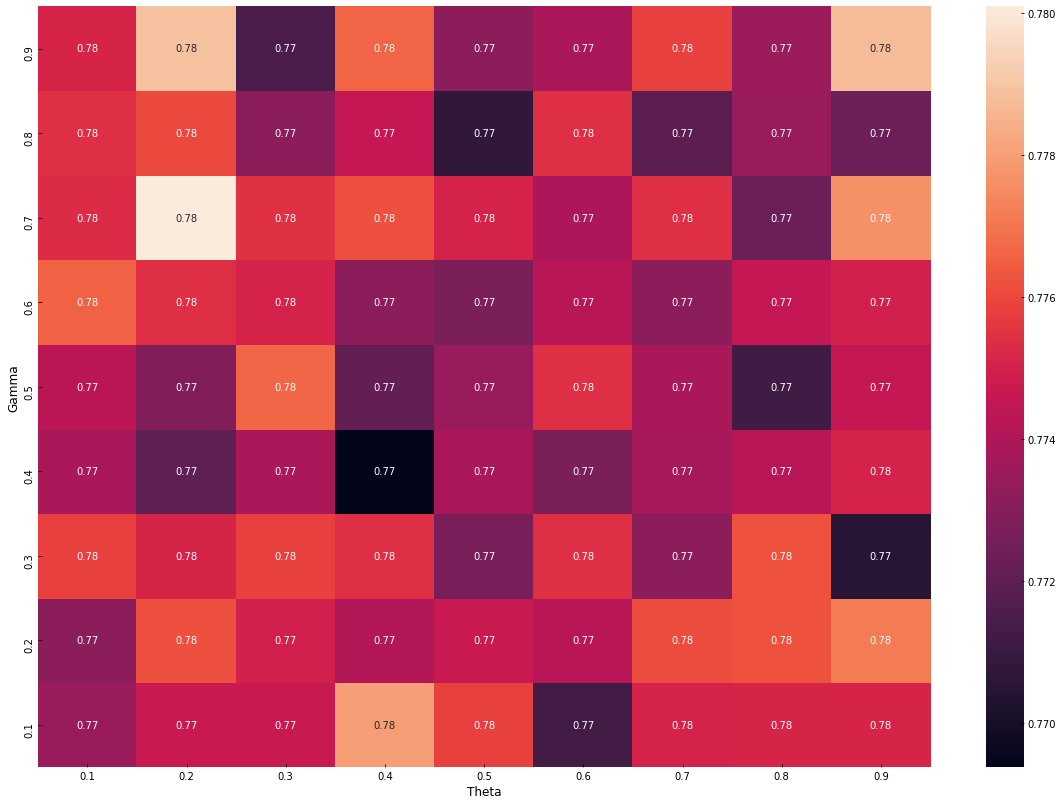

In [21]:
heatmap1_data = pd.pivot_table(results, values='f1_score', index=['Gamma'], columns='Theta')

fig, ax = plt.subplots(figsize=(20,14))
ax = sns.heatmap(heatmap1_data, annot=True, ax=ax)
ax.invert_yaxis()
plt.savefig('heatmap.png')